In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm, beta, gamma
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau

In [3]:
#%pip install copulae pycop

In [3]:
# Load libraries
import copulae

import pycop

from copulae import pseudo_obs
from copulae.archimedean import ClaytonCopula, GumbelCopula, FrankCopula
from copulae.elliptical import GaussianCopula, StudentCopula
from copulae.gof.goodness_of_fit import gof_copula
from copulas.multivariate import GaussianMultivariate



plt.rcParams["figure.figsize"] = (16, 9)  # Figure size and width

**Figure 2: Flow Chart to Use a Copula Function and Marginal CDFs of $X$ and $Y$ to Build Joint CDF of $X$ and $Y$**

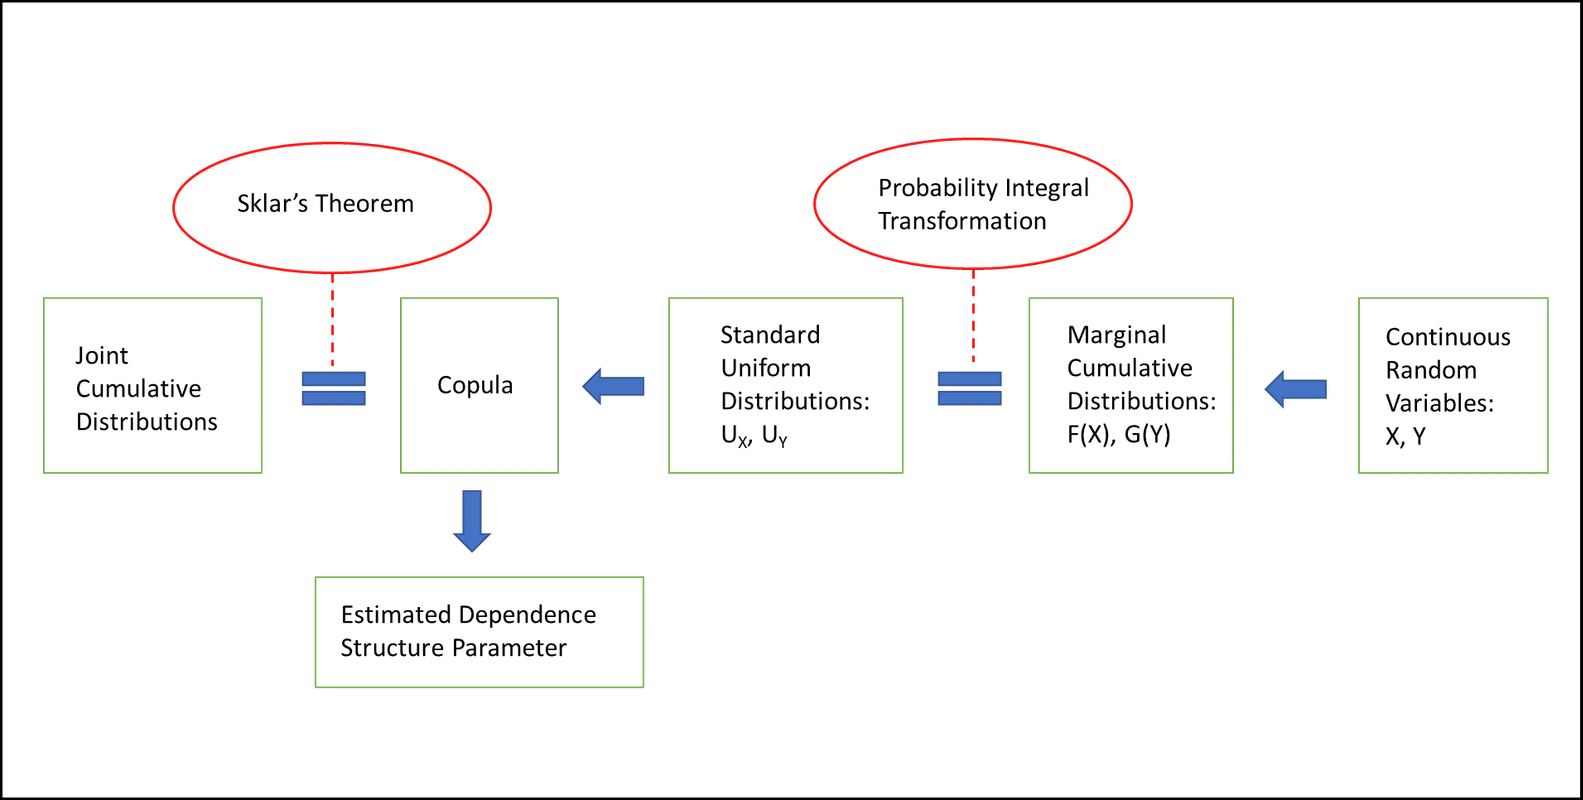


In [4]:
# Function to calculate correlation coefficient between two arrays


def corr(x, y, **kwargs):
    # Calculate the value
    coef = spearmanr(x, y)[0]
    coef_k = kendalltau(x, y)[0]
    # Make the label
    label = r"$\rho$ = " + str(round(coef, 2))
    label = label + r" et $\tau$ = " + str(round(coef_k,2))

    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy=(0.3, 0.15), size=20, xycoords=ax.transAxes)

def plot(x):
    # Create the default pairplot
    grid = sns.pairplot(
        pd.DataFrame(x), height=3
    )

    # Map a scatter plot and Pearson correlation coefficient to the upper triangle
    grid = grid.map_upper(plt.scatter)
    grid = grid.map_upper(corr)

    # Map a histogram to the diagonal
    # grid = grid.map_diag(plt.hist)

    # Map a density plot and regression line to the lower triangle
    grid = grid.map_lower(sns.kdeplot)
    grid = grid.map_lower(sns.regplot, lowess=True, line_kws={"color": "red"})

# Introduction

---

L'objectif de la présent étude est d'évaluer, au moyen d'une CVAR à 99%, le risque de crédit sur un portefeuille composé de deux créances, issues du secteur bancaire, de même notionnel 1000 EUR et de même maturité 4 ans.

La première est une obligation BNP senior de taux de recouvrement de moyenne 60% et de volatilité 15%, et la seconde est une obligation Société Générale junior (ou subordonnée) de taux de recouvrement de moyenne 30% et de volatilité 25%. On suppose qu’il n’y a pas de dépendance entre les taux de recouvrement.

La perte de crédit attendue sur ce portefeuille peut s'écrire sous la forme mathématique suivante
$L= EAD_{BNP} (1 - R_{BNP}) \mathbf{1}_{\tau_{BNP} \leq 4} + EAD_{SG} (1 - R_{SG}) \mathbf{1}_{\tau_{SG} \leq 4}$ où 
- $EAD_i$ est la perte en cas de défaut. Dans notre cas elle au notionnel;
- $R_i$ est le taux de recouvrement;
- $\tau_i$ est le moment de survenu du défaut.

Nous souhaitons retrouver une CVAR à 99% qui s'écrit $CVAR_{99\%} = inf\{x, \mathbf{P}(L \leq x) \geq 99\%\}$.

Dans l'expression donnée de la perte, on note la présence de variables aléatoires (le taux de recouvrement et le moment de survenu du défaut). La caractérisation des pertes est donc conditionnée par la connaissance des distributions de ces variables.

# Extraction des probabilités de défau implicite à partir des spreads de CDS.

---

Objectif: Estimer les probabilités de défaut (PD) pour BNP et SG en utilisant les spreads des Credit Default Swap (CDS).

La PD implicite peut être approximée par la formule $PD_i (T) = \frac{S_i(T)}{1 - R}$
où $S_i(T)$ est le spread CDS de maturité T, et $R$ est le taux de recouvrement supposé pour ce spread.

On considère que les spreads de CDS de BNP et SG de maturité 4 ans sont respectivement 100bp et 120bp et ceux de maturité 5ans, 120bp et 150bp. Les CDS ont été évalués avec un taux de recouvrement égal à 40%.

In [5]:
def proba_defaut(spread, T=4, recovery = 0.4):
    lambd = spread / (1-recovery)
    return 1-np.exp(-T*lambd)

In [6]:
# Spread de maturité 4 ans
T = 4
spread_bnp = 0.01
spread_sg = 0.012

# Proba de défaut
print("Probabilités implicite extraites des spreads  de maturité 4 ans: \n") 
print("PD BNP :\t", round(proba_defaut(spread = spread_bnp, T=T),3))
print("PD SG :\t", round(proba_defaut(spread = spread_sg, T=T),3))

Probabilités implicite extraites des spreads  de maturité 4 ans: 

PD BNP :	 0.064
PD SG :	 0.077


In [7]:
# Spread de maturité 5 ans
T = 5
spread_bnp = 0.012
spread_sg = 0.015

# Proba de défaut
print("Probabilités implicite extraites des spreads  de maturité  ans: \n") 
print("PD BNP :\t", round(proba_defaut(spread = spread_bnp, T=T),3))
print("PD SG :\t", round(proba_defaut(spread = spread_sg, T=T),3))

Probabilités implicite extraites des spreads  de maturité  ans: 

PD BNP :	 0.095
PD SG :	 0.118


- Pour les spreads de CDS de BNP et SG de maturité 4 ans valant respectivement 100bp et 120bp, avec un taux de recouvrement de 40%:
  BNP a une probabilité de défaut implicite de 6.4% contre 7.7% pour SG.

- Pour les spreads de CDS de BNP et SG de maturité 5ans valant respectivement 120bp et 150bp, avec un taux de recouvrement de 40%:
  BNP a une probabilité de défaut implicite de 7.7% contre 9.5% pour SG.

On remarque que la probabilité de défaut de BNP est moins élevé quie celle de SG dans chacun des scénarios. Ces probabilité de défaut sont croissantes avec la maturité des spreads.

L'obligation de BNP est de meilleure qualité d'un point de vu du risque défaut encouru. Cette observation est cohérente avec les données du problèmes qui spécifie que les obligations de BNP sont de type senior tandis que celles de SG sont de type junior.

# Carctérisation des distributions des taux de recouvrement

---
Objectif: Définir les distributions des taux de recouvrement des deux obligations.

Les taux de recouvrement, supposé indépendants, prennent des valeurs comprisent entre 0 et 1. Ils sont généralement modélisé par une loi béta. $R_i \sim \mathcal{B}eta(a_i,b_i)$ avec $a_i$ et $b_i$ entièrement déterminés par la moyenne et la volatilité.

Le taux de recouvrement de l'obligation BNP est en moyenne de 60% avec une volatilité de 15%. Pour l'obligation SG, le taux de recouvrement est en moyenne 2 fois moins élevé, avec une volatilité de 25%. La perte encourue sur une obligation SG au moment du défaut est donc en moyenne deux fois plus importante que celle d'une obligation BNP.

In [8]:
# Caractérisation des taux de recoubvrement
def recovery_rate(mu, sigma, size=100_000):
    a = mu*(mu*(1-mu)/sigma**2 - 1)
    b =(1- mu)*(mu*(1-mu)/sigma**2 - 1)
    return  np.random.beta(a,b, size=size)
    


Text(0, 0.5, 'Densité')

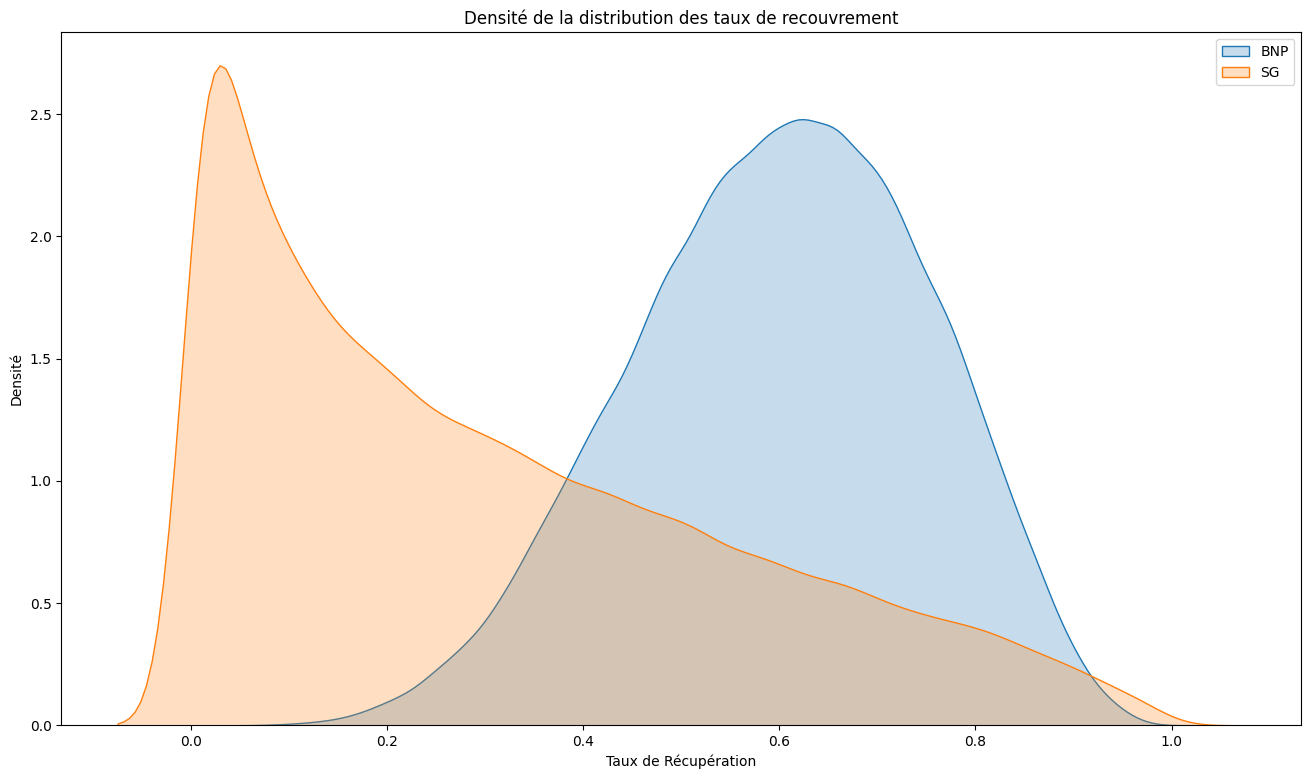

In [11]:
# Simulation des taux de recouvrement
recovery_bnp = recovery_rate(mu = 0.6, sigma = 0.15)
recovery_sg = recovery_rate(mu = 0.3, sigma = 0.25)

# Tracer les distributions KDE
sns.kdeplot(recovery_bnp, label="BNP", shade=True)
sns.kdeplot(recovery_sg, label="SG", shade=True)

# Ajouter la légende et afficher le graphe
plt.legend()
plt.title("Densité de la distribution des taux de recouvrement")
plt.xlabel("Taux de Récupération")
plt.ylabel("Densité")

# Historique des données

---
Objectif: Etudier la distibution des rendements des actions BNP et SG.*

Le portfeuille étudié est porteur de deux facteurs de risque non-idépendants. En effet, la surevenu du défaut sur l'obligation BNP peut être d'une du défaut sur l'obligation SG (ou inversement). D'abord parcequ'il agit des acteurs du même secteurs sur qui pèsent des risques communs. Il est donc crucial d'identifier la structure de dépendance de ces deux facteurs. Pour ce faire, première idée est d'identifier sur le marché les données sur les défauts enregistrés pour les obligations émises par ces deux entreprises. Malheureusement (ou non :), nous ne disposons pas de telles données. Nous allons donc utiliser un autre élément: les rendement des actions de ces deux entrises dont les prix sont accessibles.

## Analyse exploration des facteurs de risque (des actions BNP et SG)

Text(0, 0.5, 'Prix')

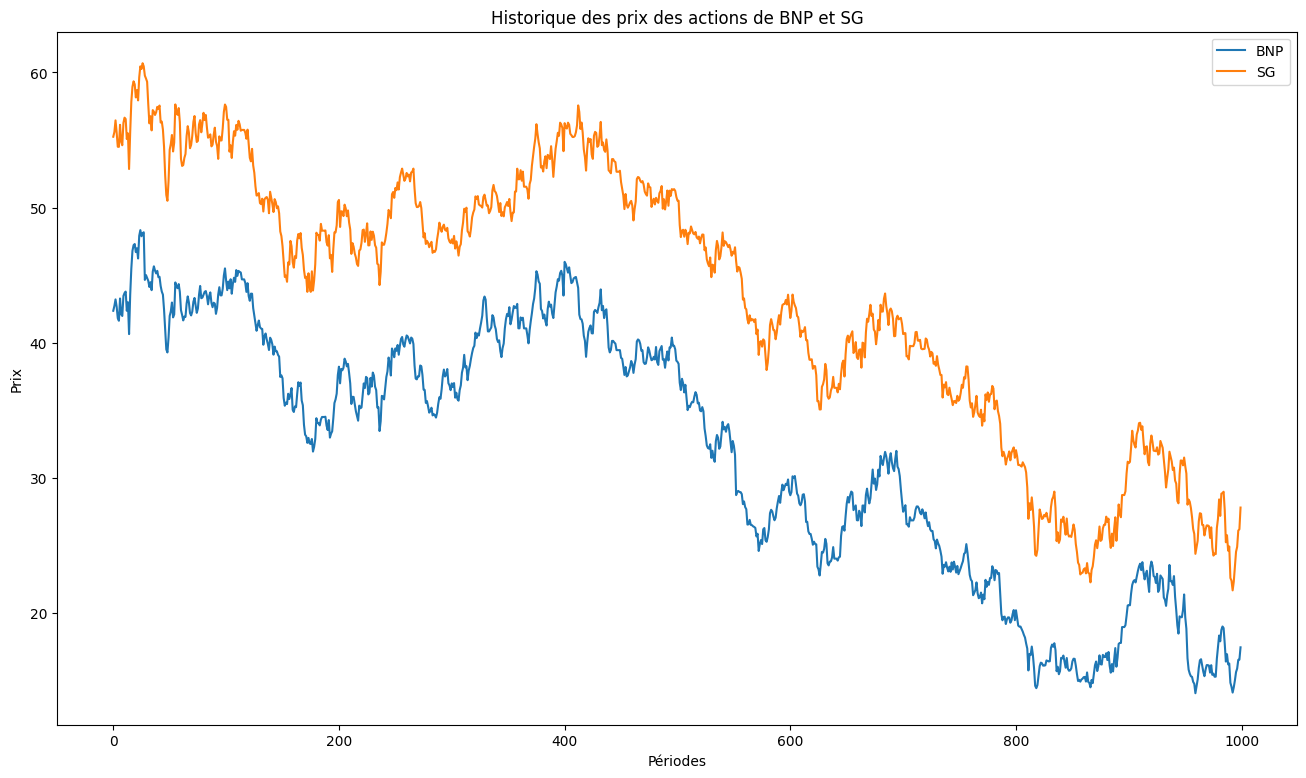

In [9]:
# Historiques des prix des actions
stock = pd.read_csv("data.txt", sep = "\t")

stock.plot()

# Ajouter la légende et afficher le graphe
plt.legend()
plt.title("Historique des prix des actions de BNP et SG")
plt.xlabel("Périodes")
plt.ylabel("Prix")

Text(0, 0.5, 'Rendement')

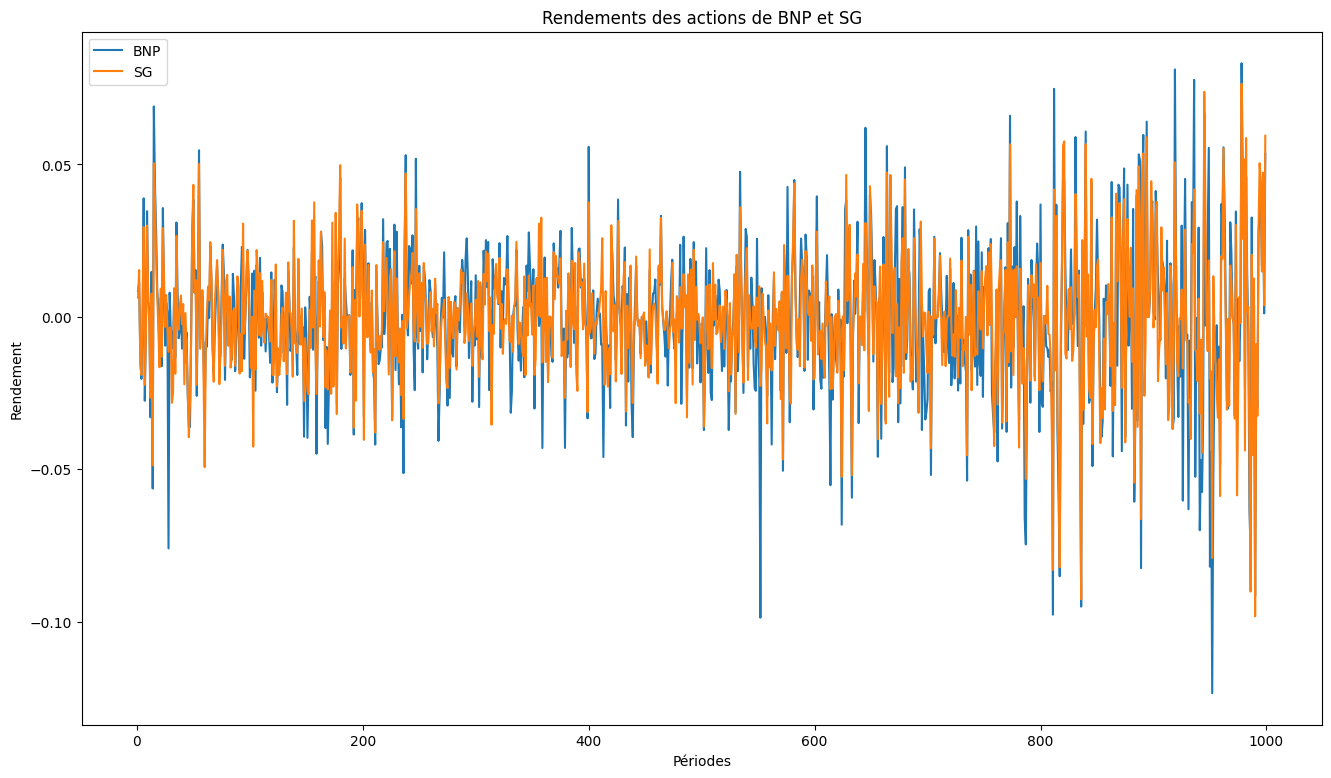

In [10]:
# Rendement(log) des actions des deux entreprises
stock = np.log(stock) - np.log(stock.shift())
stock.dropna(inplace=True)

stock.plot()

# Ajouter la légende et afficher le graphe
plt.legend()
plt.title("Rendements des actions de BNP et SG")
plt.xlabel("Périodes")
plt.ylabel("Rendement")

In [14]:
# Resumé statistique des rendements des deux entreprises
print(stock.describe())
print("\n","--"*10)

print("Skewness \n")
print(stock.skew())
print("\n","--"*10)

print("Excess Kurtosis\n")
print(stock.kurtosis())
print("\n","--"*10)

              BNP          SG
count  999.000000  999.000000
mean    -0.000888   -0.000687
std      0.024441    0.020731
min     -0.123524   -0.098292
25%     -0.013867   -0.011830
50%     -0.000358   -0.000547
75%      0.012526    0.011223
max      0.083225    0.076478

 --------------------
Skewness 

BNP   -0.331426
SG    -0.179733
dtype: float64

 --------------------
Excess Kurtosis

BNP    2.016973
SG     2.097393
dtype: float64

 --------------------


BNP et SG enregistrent des rendement moyens négatifs de l'ordre de $10^{-4}$ sur la période considérée, avec une volatilité de 2.44% pour BNP contre 2.07% pour SG. 

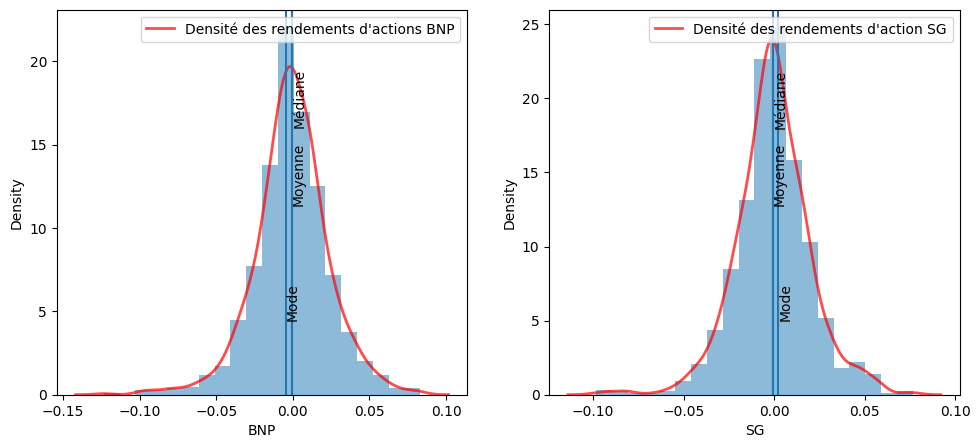

In [11]:
# Mean, Median, and Mode Relationships for Symmetric, Right-Skew and Left-Skew Distributions

# Helper HistogramPlot function
def HistogPlot(data, label):
    sns.kdeplot(data, color = "r", lw=2, alpha=0.7, label=label)  # Density
    n, bins, patches = plt.hist(
        data, bins=20, density=True, histtype="stepfilled", alpha=0.5
    )  # Histogram
    
    # Define text positioning dynamically
    ymax = plt.ylim()[1]  # Get the max y value for positioning text

    # Add Mean
    plt.axvline(x=np.mean(data))
    plt.text(np.mean(data), ymax * 0.5, "Moyenne", rotation=90)

    # Add Median
    plt.axvline(x=np.median(data))
    plt.text(np.median(data), ymax * 0.7, "Médiane", rotation=90)

    # Add Mode (by the most frequent bin)
    plt.axvline(x=(bins[n.argmax()] + bins[n.argmax() + 1]) / 2)
    plt.text((bins[n.argmax()] + bins[n.argmax() + 1]) / 2, ymax * 0.2, "Mode", rotation=90)
    plt.legend()


# Plot
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(131)
HistogPlot(stock["BNP"], "Densité des rendements d'actions BNP")
ax2 = plt.subplot(132)
HistogPlot(stock["SG"], "Densité des rendements d'action SG")
plt.show()

Les rendements des actions des deux entreprises semblement symétriques si l'on se limite à leurs moyennes et leur médianes. Seulement le mode de chacune des distribution est inférieur à la moyenne des rendement, avec des coefficient d'asymétrie non-nul (skew_BNP = -0.331, skew_SG = -0.179). Ce qui indique la présence d'une asymétrie à droite. Ainsi les rendement les plus souvent observés sont inférieurs à leurs moyennes.

Aussi, on observe que les queues de distribution sont plus épaissent que celle d'une distribution gaussienne (kurtosis_bnp = 5.016, kurtosis_SG = 5.097). En d'autres termes, ces deux rendements présentent plus de valeurs extrêmes qu'une distribution gaussienne.

## Modélisation des distributions univariées des acteurs de risques


La présence d'asymétrie et d'excess de kurtosis indique qu'une modélisation gaussienne des rendement des deux entreprises n'est pas envisageable. Il serait plus adéquat de les modéliser par une Student pour prendre en compte les queues épaissent. Les effet d'asymétrie quant à eux pourrons être pris en compte conjointement avec 'excess de kurtosis en modélisant une skew-Student.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, t, kstest, skew

from skew_student import*  # Import de la Skew-Student

def modeliser_distribution(data):
    """
    Modélise une distribution normale, Student et Skew-Student, compare les ajustements et sélectionne la meilleure.
    
    Paramètre :
    - data : array NumPy contenant l'échantillon de données.
    
    Retour :
    - Un dictionnaire contenant la distribution sélectionnée et les p-values du KS test.
    """
    
    #  1. Estimation des paramètres
    mu_norm, sigma_norm = norm.fit(data)  # Loi normale
    df_t, loc_t, scale_t = t.fit(data)  # Loi de Student
    mu_skew, sigma_skew, gamma_skew, nu_skew = optimize_parameters(data)  # Loi Skew-Student
    
    print("--"*10,"PARAMETRES ESTIMES", "--"*10)
    print(f"Loi Normale - Moyenne: {mu_norm:.3f}, Écart-type: {sigma_norm:.3f}")
    print(f"Loi de Student - df: {df_t:.3f}, Moyenne: {loc_t:.3f}, Échelle: {scale_t:.3f}")
    print(f"Loi Skew-Student - μ: {mu_skew:.3f}, σ: {sigma_skew:.3f}, γ: {gamma_skew:.3f}, ν: {nu_skew:.3f}")
    print("--"*30)
    
    #  2. Affichage des Q-Q Plots juxtaposés
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 3 colonnes pour ajouter la Skew-Student

    # Q-Q Plot pour la loi Normale
    stats.probplot(data, dist="norm", sparams=(mu_norm, sigma_norm), plot=axes[0])
    axes[0].set_title("Q-Q Plot - Loi Normale")
    axes[0].grid()

    # Q-Q Plot pour la loi de Student
    stats.probplot(data, dist="t", sparams=(df_t, loc_t, scale_t), plot=axes[1])
    axes[1].set_title("Q-Q Plot - Loi de Student")
    axes[1].grid()

    # Q-Q Plot pour la loi Skew-Student
    sorted_data = np.sort(data)
    n = len(data)
    quantiles_skew = skew_student_ppf((np.arange(1, n + 1) - 0.5) / n, mu_skew, sigma_skew, gamma_skew, nu_skew)

    axes[2].scatter(quantiles_skew, sorted_data, color="blue", alpha=0.6)
    axes[2].plot(quantiles_skew, quantiles_skew, 'r--')  # Ligne théorique (y=x)
    axes[2].set_title("Q-Q Plot - Loi Skew-Student")
    axes[2].grid()

    plt.tight_layout()
    plt.show()
    
    #  3. Test KS (Kolmogorov-Smirnov)
    ks_stat_norm, ks_pval_norm = kstest(data, "norm", args=(mu_norm, sigma_norm))
    ks_stat_t, ks_pval_t = kstest(data, "t", args=(df_t, loc_t, scale_t))
    
    # KS-Test pour la Skew-Student
    np.random.seed(42)
    sim_data = skew_student_sim(mu_skew, sigma_skew, gamma_skew, nu_skew, size = 100_000)
    ks_stat_skew, ks_pval_skew =  kstest(data,sim_data)

    print(f"KS Test - Loi Normale: Stat={ks_stat_norm:.3f}, p-value={ks_pval_norm:.3f}")
    print(f"KS Test - Loi de Student: Stat={ks_stat_t:.3f}, p-value={ks_pval_t:.3f}")
    print(f"KS Test - Loi Skew-Student: Stat={ks_stat_skew:.3f}, p-value={ks_pval_skew:.3f}")

    #  4. Sélection de la meilleure distribution
    p_values = {"Normale": ks_pval_norm, "Student": ks_pval_t, "Skew-Student": ks_pval_skew}
    best_dist = max(p_values, key=p_values.get)  # Sélectionne la distribution avec la plus grande p-value
    print(f" Distribution sélectionnée: {best_dist}")
    
    return {
        "Distribution": best_dist, 
        "p-value Normale": ks_pval_norm, 
        "p-value Student": ks_pval_t, 
        "p-value Skew-Student": ks_pval_skew
    }


Modélisation des rendements des actions BNP

-------------------- PARAMETRES ESTIMES --------------------
Loi Normale - Moyenne: -0.001, Écart-type: 0.024
Loi de Student - df: 4.533, Moyenne: -0.001, Échelle: 0.019
Loi Skew-Student - μ: 0.002, σ: 0.019, γ: -0.152, ν: 4.587
------------------------------------------------------------


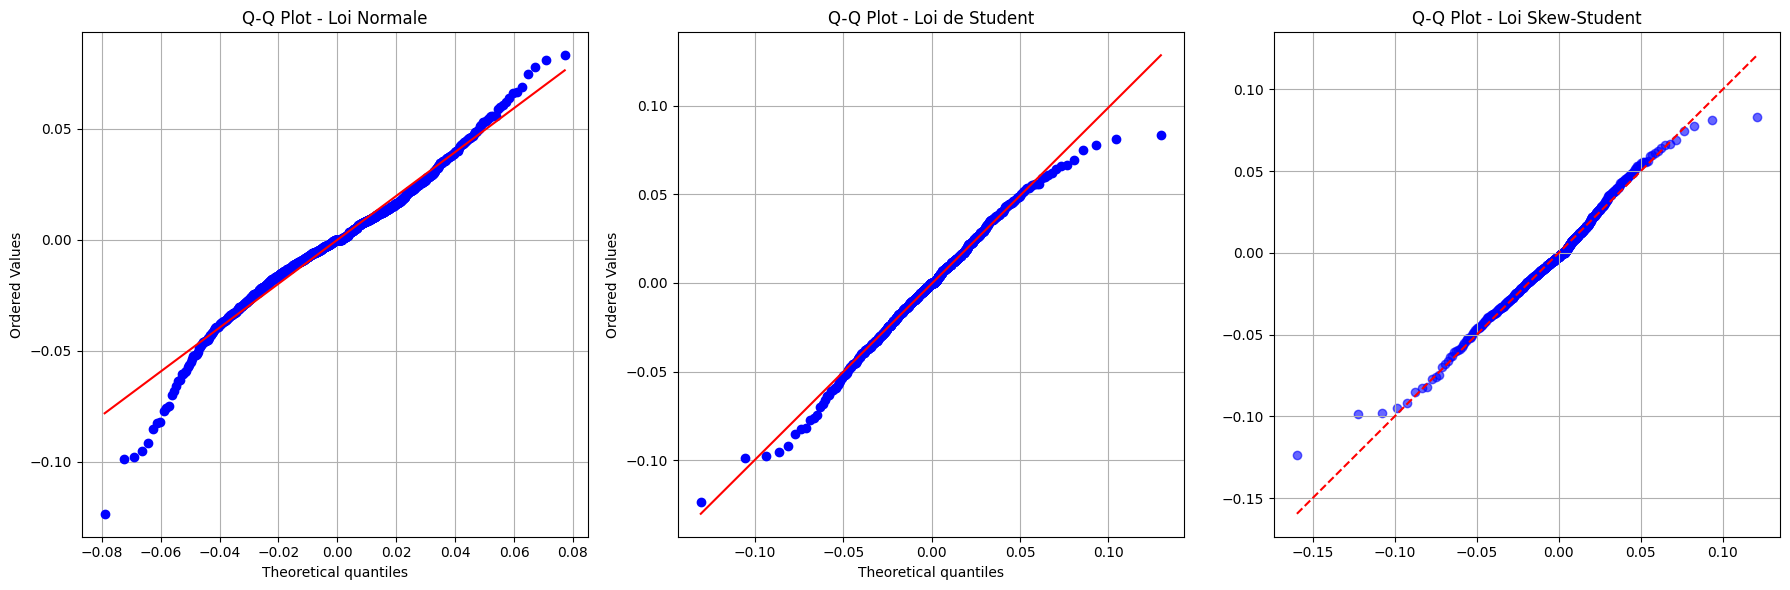

KS Test - Loi Normale: Stat=0.055, p-value=0.004
KS Test - Loi de Student: Stat=0.026, p-value=0.487
KS Test - Loi Skew-Student: Stat=0.023, p-value=0.681
 Distribution sélectionnée: Skew-Student
------------------------------------------------------------ 

Modélisation des rendements des actions SG

-------------------- PARAMETRES ESTIMES --------------------
Loi Normale - Moyenne: -0.001, Écart-type: 0.021
Loi de Student - df: 4.593, Moyenne: -0.001, Échelle: 0.016
Loi Skew-Student - μ: -0.002, σ: 0.016, γ: 0.073, ν: 4.585
------------------------------------------------------------


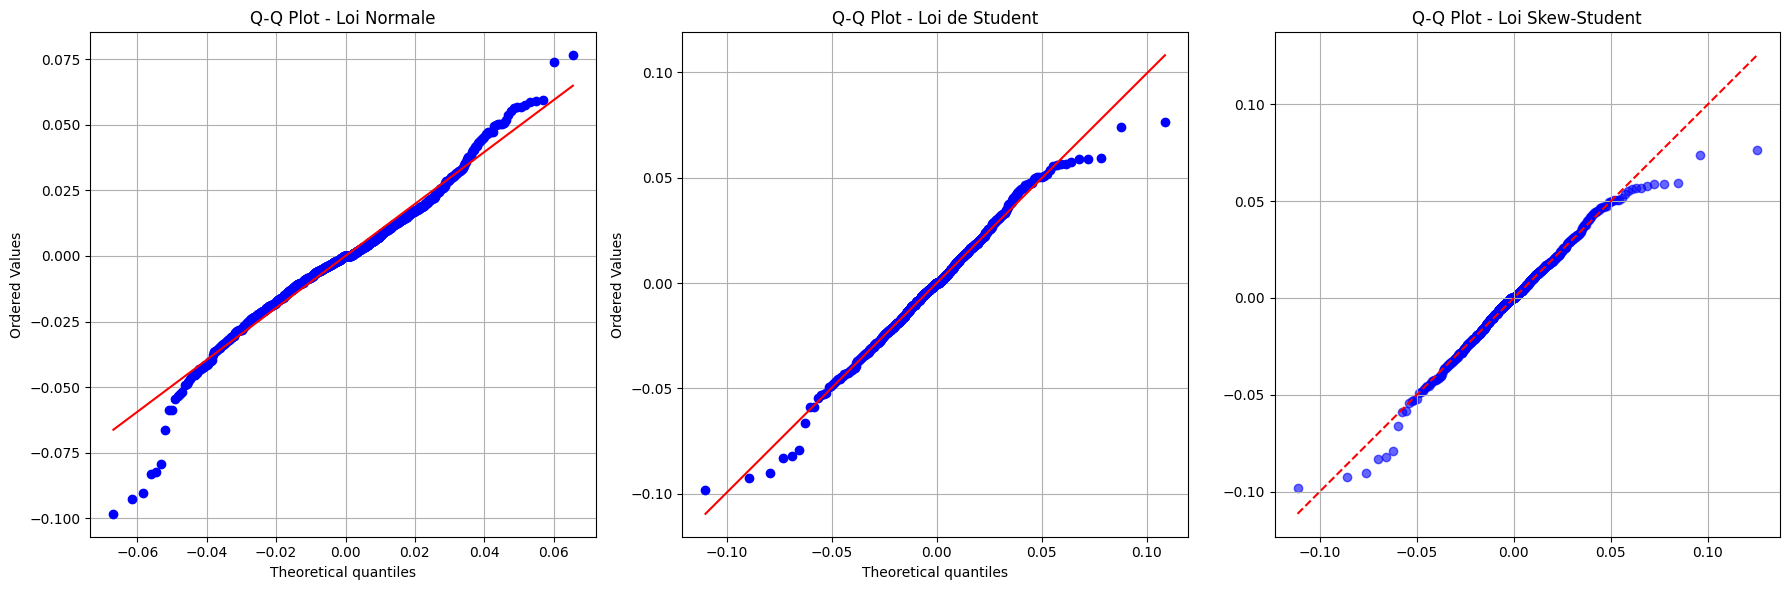

KS Test - Loi Normale: Stat=0.049, p-value=0.015
KS Test - Loi de Student: Stat=0.025, p-value=0.559
KS Test - Loi Skew-Student: Stat=0.029, p-value=0.373
 Distribution sélectionnée: Student


In [17]:
from skew_student import *
from scipy.stats import kstest, norm, t, ks_2samp

# Modélisation des rendement 
print("Modélisation des rendements des actions BNP\n")
resultats_BNP = modeliser_distribution(stock["BNP"])

print("--"*30,"\n")

print("Modélisation des rendements des actions SG\n")
resultats_SG = modeliser_distribution(stock["SG"])



A la lecture des QQ_plot, 
- les rendements de BNP s'ajustent mieux à l'aide d'une skew-student (confirmation par le test de Kolmogorov-Smirnov, p-value = 0.68). Toutefois les queues de distribution semblent ne pas être bien ajustées.
- les rendements de SG s'ajustent aussi bien à l'aide d'une skew-student qu'à l'aide d'une student. Nous privilégions donc un modèle simple en retenant une student (p-value = 0.559, ks-test).

# Étude la structure de dépendance entre les facteurs de risques sur la base de critères non paramétriques. 

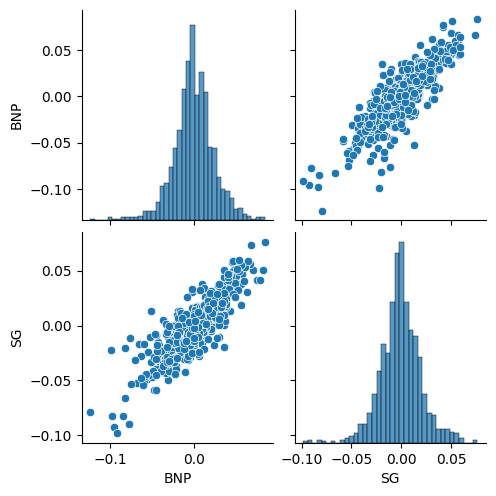

In [34]:
# Nuage de points
sns.pairplot(stock)

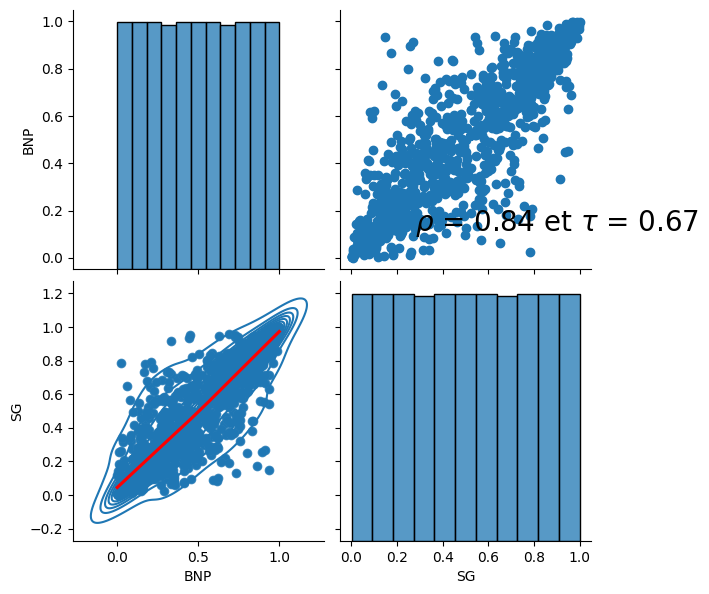

In [18]:
# Transformation U = F_X(X)
var_bnp = pseudo_obs(stock["BNP"])
var_sg = pseudo_obs(stock["SG"])

U = pseudo_obs(stock)
plot(U)

Le coefficient de spearman calculé sur les rendements des BNP et SG est élevé et positif, ce qui suggère l'existence d'une dépendance positive entre les deux facteurs de risque.
Le nuage des points des pseudo-observations semble indiquer une struture de dépendance elliptique entre les facteurs de risque. Plus particulièrement une dépendance t-student car les fines pointes dans l'extrêmité supérieure droite et inférieure gauche du graphique semble indiquer une dépendance de queu à gauche et à droite.

# Modelisation de la structure de dependance

---
Objectif: Modélisation paramétrique de la structure de dépendance au moyen d'une copule. La qualité d'ajustement sera évaluée graphiquement à l'aide de dépendogrammes et de kendallplot, et statistiquement par le blancket-test.

Le nuage des points des pseudo-observations semble indiquer une struture de dépendance elliptique entre les facteurs de risque. Plus particulièrement une dépendance t-student car les fines pointes dans l'extrêmité supérieure droite et inférieure gauche du graphique semble indiquer une dépendance de queu à gauche et à droite.

In [13]:
import scipy.stats as st
from statsmodels.distributions.copula.api import StudentTCopula

# Fonction de répartition enpirique bivariée
def ecdf_bi(data):
    n = len(data)
    
    # Convertir les données en array numpy pour une meilleure performance
    data_array = data.to_numpy()
    
    # Créer un tableau pour stocker la valeur de la fonction de répartition empirique
    F_n = np.zeros(n)
    
    for i in range(n):
        x_i, y_i = data_array[i]
        
        # Calculer la fonction indicatrice pour chaque point de données
        F_n[i] = np.sum((data_array[:, 0] <= x_i) & (data_array[:, 1] <= y_i)) / n
    
    return F_n




def student_copula_simulate_cdf(u, corr, df, n_simulations=10_000):
    """Approximatif calcul de la CDF de la copule Student par simulation."""
    copula = StudentTCopula(corr=corr, df=df)
    # Générer des simulations de la copule Student
    samples = copula.rvs(n_simulations)
    # Calculer la proportion de simulations qui sont inférieures ou égales aux valeurs dans u
    cdf_values = np.array([np.mean((samples[:, 0] <= ui[0]) & (samples[:, 1] <= ui[1])) for ui in u])
    return cdf_values


def blanket_test(data, copule, S=10):
    n = len(data)
    U_hat = pseudo_obs(pd.DataFrame([data.iloc[:,0], data.iloc[:,1]]).T)
    
    C_n_hat = ecdf_bi(U_hat)
    
    cop = copule(dim=2)
    
    if copule==StudentCopula:
        cop.fit(U_hat,  fix_df=True)
        param = cop.params
        
        # Construction de la matrice de corrélation
        corr = np.array([[1, float(param[1])], [float(param[1]), 1]])
        
        # Utilisation de la simulation numérique pour la CDF
        C_theta = student_copula_simulate_cdf(U_hat.to_numpy(), corr, float(param[0]))
    else :
        cop.fit(U_hat)
        C_theta = cop.cdf(U_hat)
    
    T_n = np.sum((C_n_hat-C_theta)**2)
        
    
    T = np.zeros(S)
    for s in range(S):
        U_s = cop.random(n)
        #U_s =  pseudo_obs(pd.DataFrame([U_s.iloc[:,0], U_s.iloc[:,1]]).T)
        
        C_s_hat = ecdf_bi(U_s)
        
        cop_s = copule(dim=2)
        if copule==StudentCopula:
            cop_s.fit(U_s, fix_df=True)
            param = cop_s.params

            # Construction de la matrice de corrélation
            corr = np.array([[1, float(param[1])], [float(param[1]), 1]])
            
            # Utilisation de la simulation numérique pour la CDF
            C_theta_s = student_copula_simulate_cdf(U_s.to_numpy(), corr, float(param[0]))
        else:
            cop_s.fit(U_s)
            C_theta_s = cop_s.cdf(U_s)
            
        T[s] = np.sum((C_s_hat-C_theta_s)**2)
        
    p_value = np.mean(T>=T_n)
    
    return T_n, p_value

In [83]:
# Define copulas to test
copulas = {
    "Student-t": StudentCopula,
    "Gaussian": GaussianCopula,
    "Clayton": ClaytonCopula,
    "Gumbel": GumbelCopula,
    "Frank": FrankCopula
}


resultats_test = {"Copule": [],"Statique":[], "p_value":[]}

for i, (name, copula) in enumerate(copulas.items()):
    res = blanket_test(stock, copule = copula, S=1000)
    resultats_test["Copule"].append(name)
    resultats_test["Statique"].append(res[0])
    resultats_test["p_value"].append(res[1])

              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288531    0.288531
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288531    0.288531
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288531    0.288531
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0

In [84]:
pd.DataFrame(resultats_test)

,Copule,Statique,p_value
0,Student-t,0.049678,0.943
1,Gaussian,0.054595,0.887
2,Clayton,0.864806,0.005
3,Gumbel,0.034857,0.975
4,Frank,0.602916,0.212


              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0

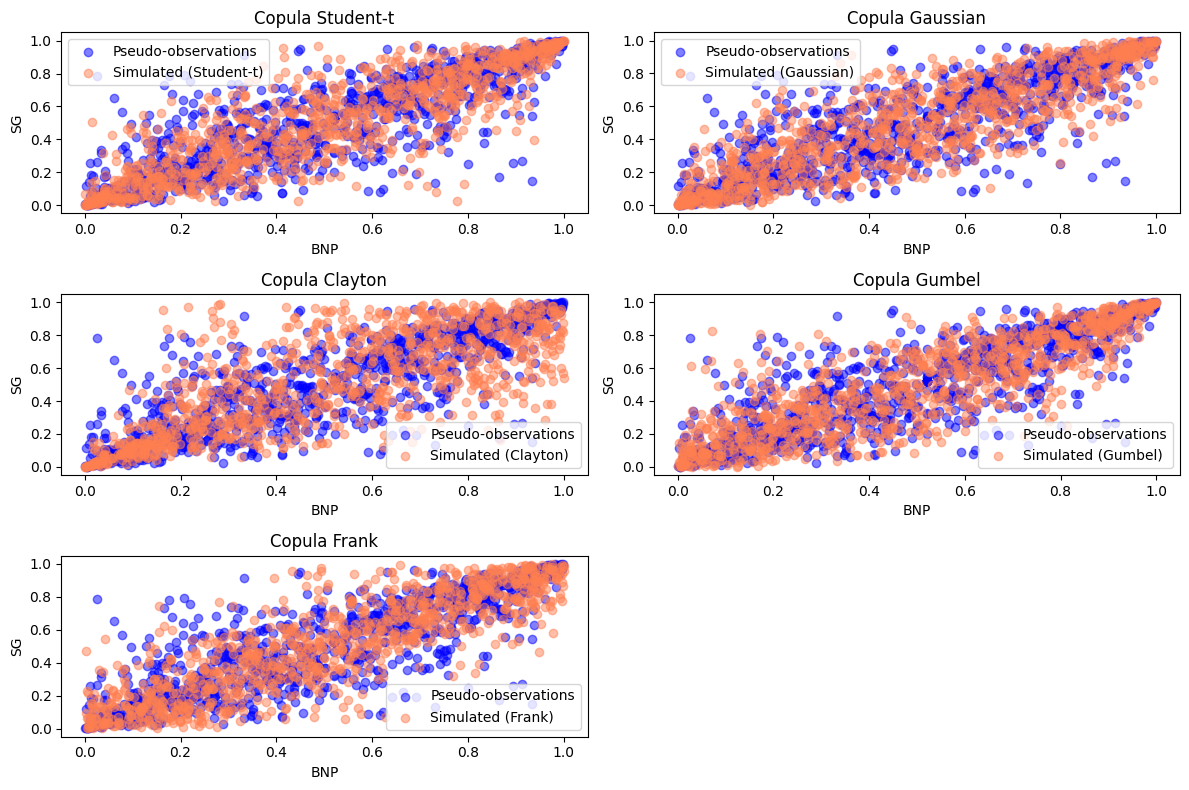

In [ ]:
# Ensure the number of subplots does not exceed available space
num_copulas = len(copulas)
num_rows = int(np.ceil(num_copulas / 2))
num_cols = min(2, num_copulas)

# Plot simulated data vs observed data
plt.figure(figsize=(12, 8))
for i, (name, copula) in enumerate(copulas.items()):
    copula.fit(stock, fix_df=True) if name == "Student-t" else copula.fit(stock)
    simulated_data = copula.random(len(stock))
    
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(var_bnp, var_sg, alpha=0.5, label="Pseudo-observations", color="blue")
    plt.scatter(simulated_data.iloc[:, 0], simulated_data.iloc[:, 1], alpha=0.5, label=f"Simulated ({name})", color="coral")
    plt.title(f"Copula {name}")
    plt.xlabel("BNP")
    plt.ylabel("SG")
    plt.legend()

plt.tight_layout()
plt.show()

              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000
              BNP          SG
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0

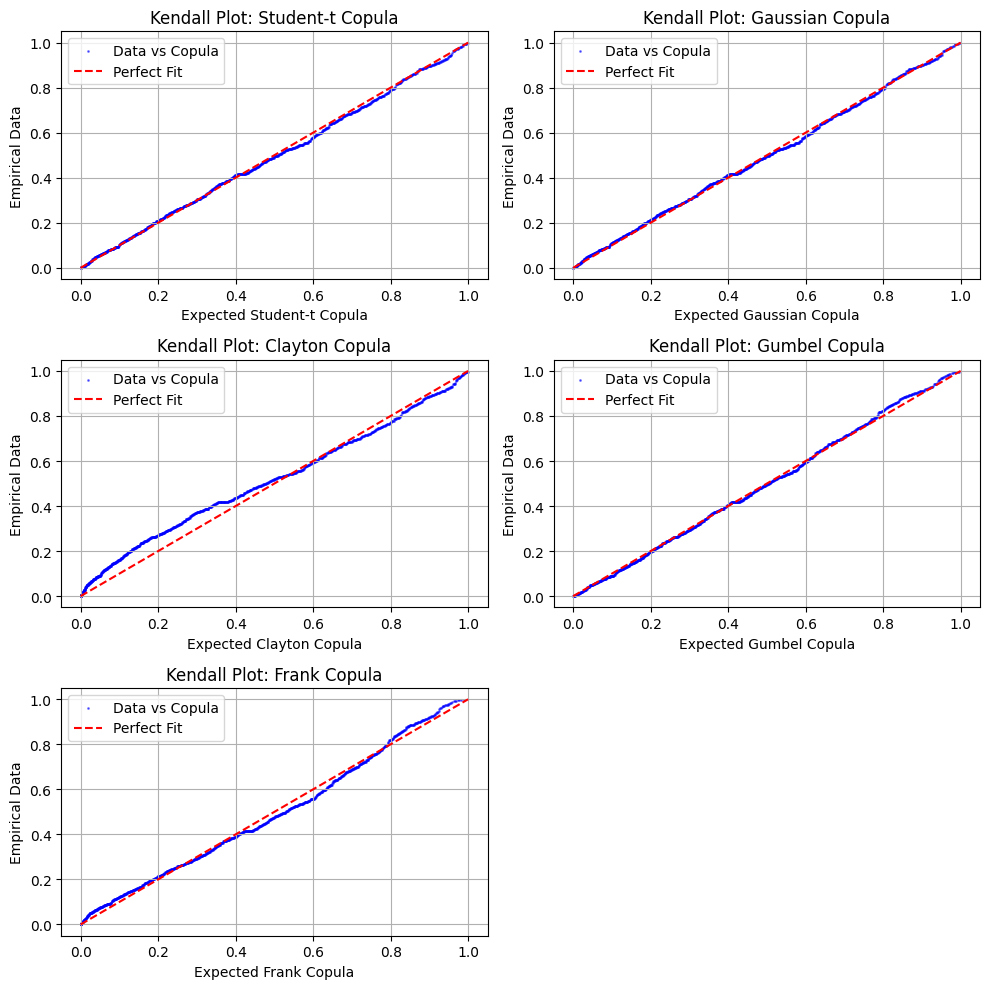

In [21]:
# Compute pseudo-observations (normalized ranks)
u = np.asarray(var_bnp)
v = np.asarray(var_sg)
n = len(u)

# Compute empirical V_i (Kendall distribution values)
mask = (u[:, None] <= u) & (v[:, None] <= v)
counts = mask.sum(axis=1)
V = (counts - 1) / (n - 1)
V_sorted = np.sort(V)

# Simulation parameters
num_simulations = 100

# Generate Kendall plots
plt.figure(figsize=(10, 10))

for i, (name, copula) in enumerate(copulas.items()):
    copula.fit(stock, fix_df=True) if name == "Student-t" else copula.fit(stock)
    
    simulated_V = np.zeros((num_simulations, n))
    
    for s in range(num_simulations):
        sim_data = copula.random(n)
        u_sim = np.asarray(sim_data.iloc[:, 0])
        v_sim = np.asarray(sim_data.iloc[:, 1])
        mask_sim = (u_sim[:, None] <= u_sim) & (v_sim[:, None] <= v_sim)
        counts_sim = mask_sim.sum(axis=1)
        simulated_V[s] = np.sort((counts_sim - 1) / (n - 1))
    
    expected_V = simulated_V.mean(axis=0)
    
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(expected_V, V_sorted, alpha=0.5, color='blue', label='Data vs Copula', s=1)
    plt.plot([0, 1], [0, 1], '--r', label='Perfect Fit')
    plt.xlabel(f'Expected {name} Copula')
    plt.ylabel('Empirical Data')
    plt.title(f'Kendall Plot: {name} Copula')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

La structure de dépendance entre les facteurs de risque est bien ajusté à l'aide d'une copule de student de paramètre $\rho = 0.86$ et $\nu = 4$. Cette observation soutenue par le dépendogramme et le kendallplot est confirmé par le blancket test (p_value = 0.57).

# Calcul de la CreditVar à 99% avec simulation de Monte Carlo

---
Objectif: Estimer la perte potentielle maximale du portefeuille à un niveau de confiance de 99%.

Ayant modéliser la structure de dépendance entre les facteurs de risques, il est désormais possible de modéliser la distribution jointe des temps défaut $(\tau_{BNP}, \tau_{SG})$, et par conséquent simuler des réalisations des pertes sur le portefeuille.

Nous simulons 1000 échantillons de 100_000 réalisation de pertes, et pour chaque échantillon nous estimons la CVaR à 99%. Ceci nous permet alors d'obtenir une estimation de la CVaR à 99% avec un intervalle de confiance.

In [26]:
M = 10_000
B = 1000

# Spread de maturité 4 ans
spread_bnp = 0.01
spread_sg = 0.012
EAD_bnp = 1000
EAD_sg = 1000


np.random.seed(42)
# Structure de dépendance

# Obtain Transformed (pseudo observations) sample
var_bnp = pseudo_obs(stock["BNP"])
var_sg = pseudo_obs(stock["SG"])
data = pd.DataFrame([var_bnp, var_sg]).T
data.columns = ["var_bnp", "var_sg"]

# Estimation de la structure de dépendance
structure_dependance = GumbelCopula()
structure_dependance.fit(data)

CVar = np.zeros(B)
for t in range(B):
    # Recouvrement
    recovery_bnp = recovery_rate(mu = 0.6, sigma = 0.15, size=M)
    recovery_sg = recovery_rate(mu = 0.3, sigma = 0.25, size=M) 

    # Probabilité de défaut 
    PD_bnp = proba_defaut(spread_bnp, T=4, recovery = 0.4)
    PD_sg = proba_defaut(spread_sg, T=4, recovery = 0.4)

    # Evènements de défaut
    u = structure_dependance.random(M)
    default_bnp = (u.var_bnp <= PD_bnp).astype(int)
    default_sg = (u.var_sg <= PD_sg).astype(int)

    # Loss function
    L = EAD_bnp*(1-recovery_bnp)*default_bnp + EAD_sg*(1-recovery_sg)*default_sg
    CVar[t] = np.quantile(L, 0.99)

          var_bnp      var_sg
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000


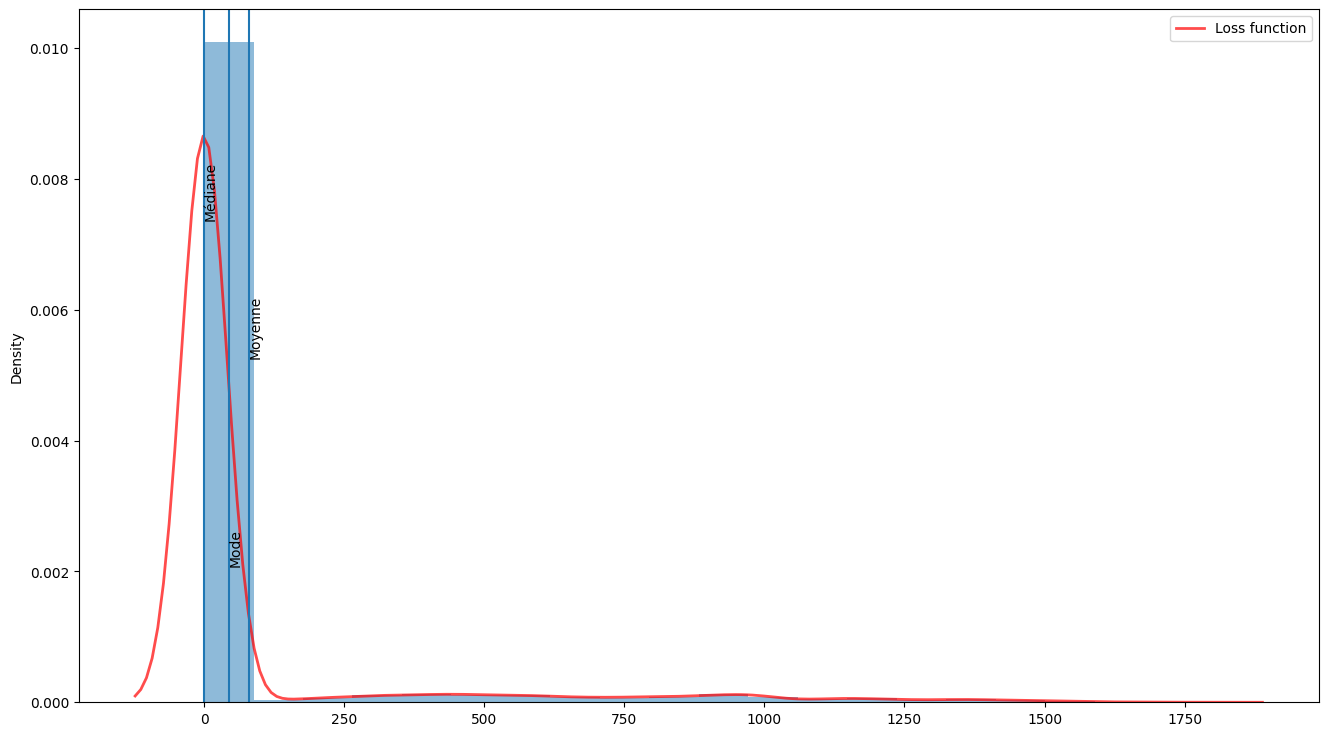

In [27]:
HistogPlot(L, label="Loss function")


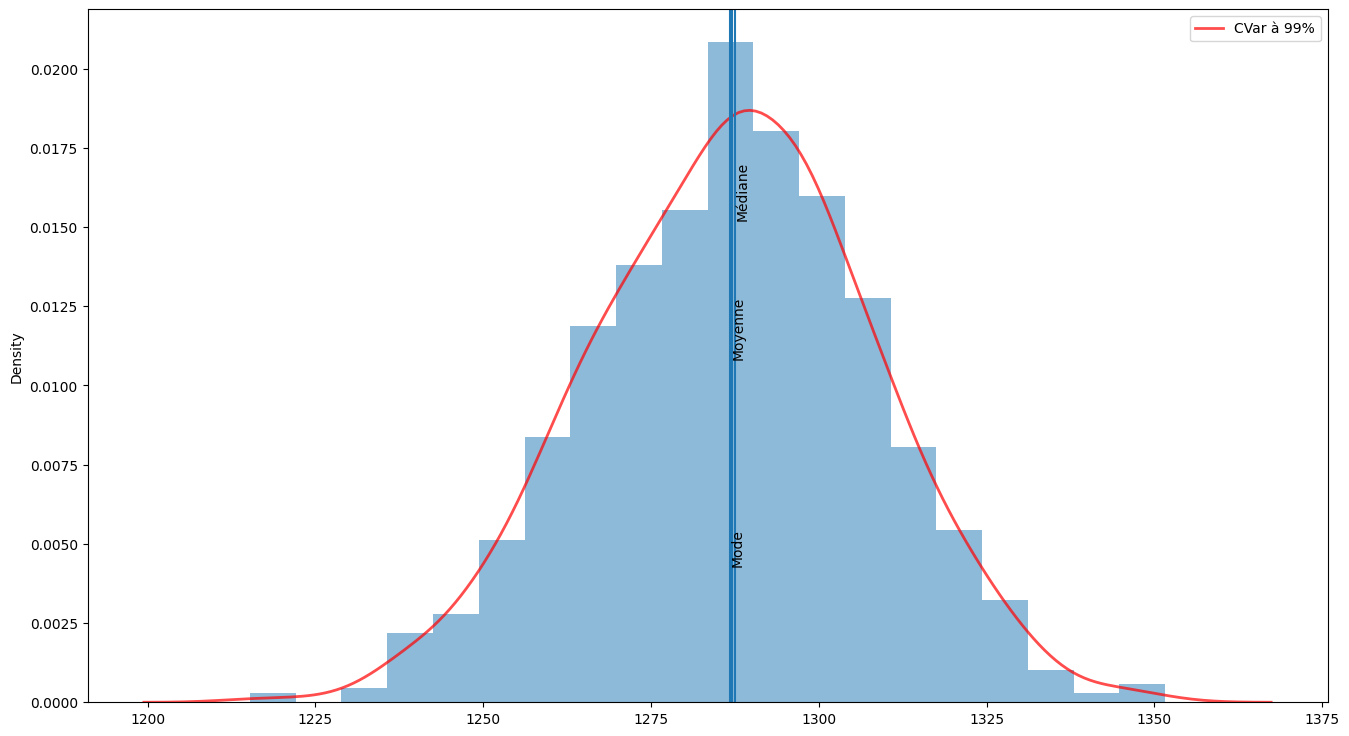

In [28]:

# Estimation d'une CVaR à 99%
HistogPlot(CVar, label="CVar à 99%")

In [29]:
# CVAR
print("CVaR à 99%:\t", round(CVar.mean(),2))
print("IC à 95% de la CVaR à 99% :\t [", round(np.quantile(CVar, 1 - 0.975),2),
                                       round(np.quantile(CVar, 0.975),2),
                                       "]")


CVaR à 99%:	 1287.03
IC à 95% de la CVaR à 99% :	 [ 1245.81 1327.01 ]


In [ ]:
# Evaluer la convergence de la CVaR

def  calcul_CVaR(M,B):
    CVar = np.zeros(B)
    for t in range(B):
        # Recouvrement
        recovery_bnp = recovery_rate(mu = 0.6, sigma = 0.15, size=M)
        recovery_sg = recovery_rate(mu = 0.3, sigma = 0.25, size=M) 

        # Probabilité de défaut 
        PD_bnp = proba_defaut(spread_bnp, T=4, recovery = 0.4)
        PD_sg = proba_defaut(spread_sg, T=4, recovery = 0.4)

        # Evènements de défaut
        u = structure_dependance.random(M)
        default_bnp = (u.var_bnp <= PD_bnp).astype(int)
        default_sg = (u.var_sg <= PD_sg).astype(int)

        # Loss function
        L = EAD_bnp*(1-recovery_bnp)*default_bnp + EAD_sg*(1-recovery_sg)*default_sg
        CVar[t] = np.quantile(L, 0.99)
    return CVar

          var_bnp      var_sg
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000


In [24]:
M = np.arange(500, 10_000, 500)
CVaR = np.array([calcul_CVaR(m,B) for m in M])


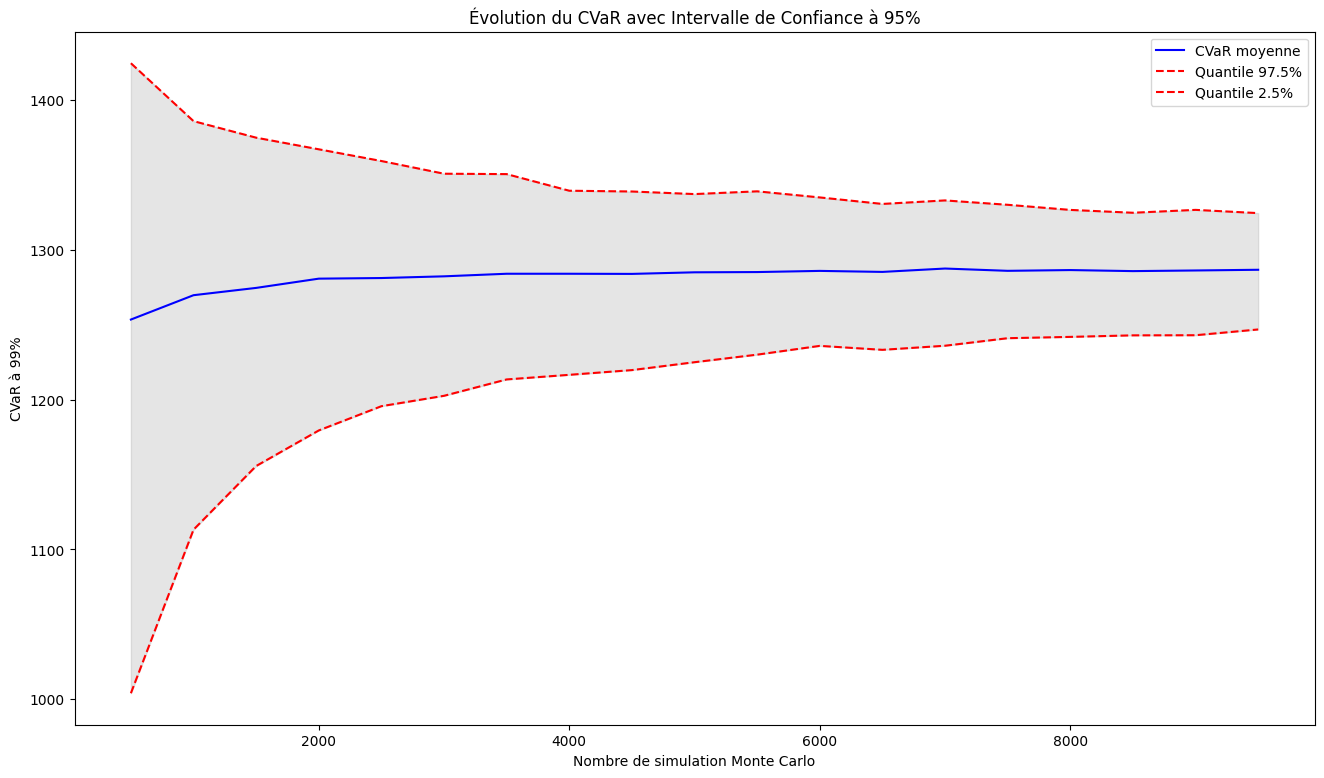

In [25]:
plt.plot(M, np.mean(CVaR, axis=1), label="CVaR moyenne", color='blue')
plt.plot(M, np.quantile(CVaR, 0.975, axis=1), label="Quantile 97.5%", linestyle="dashed", color='red')
plt.plot(M, np.quantile(CVaR, 0.025, axis=1), label="Quantile 2.5%", linestyle="dashed", color='red')

plt.fill_between(M, np.quantile(CVaR, 0.025, axis=1), np.quantile(CVaR, 0.975, axis=1), color='gray', alpha=0.2)

plt.xlabel("Nombre de simulation Monte Carlo")
plt.ylabel("CVaR à 99%")
plt.legend()
plt.title("Évolution du CVaR avec Intervalle de Confiance à 95%")
plt.show()
